# Task 7: Sales Forecasting

## Project Objective
Build a reliable weekly sales forecasting pipeline using the Walmart dataset and evaluate model performance on time-ordered data.

## Scope and Deliverables
1. Load and validate historical Walmart weekly sales data.
2. Engineer calendar, lag, and rolling features for forecasting.
3. Train and compare multiple regression models using MAE, RMSE, and R².
4. Visualize actual vs predicted sales over time.
5. Produce a next-period sales forecast with the best-performing model.

## Business Value
Accurate weekly forecasts support inventory planning, staffing decisions, and promotion timing while reducing stock-out and overstock risk.

## Workflow
This notebook loads Walmart sales data, engineers calendar/lag/rolling features, applies a strict time-based train/test split, runs time-aware cross-validation for boosting candidates, benchmarks multiple regressors on the holdout period, and produces a next-period sales forecast.

## Modeling Strategy
The project compares interpretable linear baselines with stronger non-linear ensemble regressors. Model selection is informed by both 5-fold `TimeSeriesSplit` validation (for boosting libraries) and final holdout evaluation on the last 20% of the timeline to preserve realistic forecasting conditions and avoid leakage.

In [25]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)

sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("Libraries imported successfully.")

Libraries imported successfully.


In [26]:
# Load dataset (supports direct and relative paths)
possible_paths = [
    "/Users/emmanuel.siyanbola/Downloads/Machine Learning Track/Walmart_Sales.csv",
    "../../Walmart_Sales.csv",
    "../Walmart_Sales.csv",
    "Walmart_Sales.csv"
]

dataset_path = next((p for p in possible_paths if os.path.exists(p)), None)
if dataset_path is None:
    raise FileNotFoundError("Walmart_Sales.csv not found in expected locations.")

sales_df = pd.read_csv(dataset_path)
print(f"Loaded dataset from: {dataset_path}")
print(f"Shape: {sales_df.shape}")
sales_df.head()

Loaded dataset from: /Users/emmanuel.siyanbola/Downloads/Machine Learning Track/Walmart_Sales.csv
Shape: (6435, 8)


,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


In [27]:
# Parse date, sort records, and create time/lag features
sales_df['Date'] = pd.to_datetime(sales_df['Date'], format='%d-%m-%Y', errors='coerce')
if sales_df['Date'].isna().sum() > 0:
    raise ValueError("Some dates could not be parsed. Check the source format.")

sales_df = sales_df.sort_values(['Store', 'Date']).reset_index(drop=True)

sales_df['year'] = sales_df['Date'].dt.year
sales_df['month'] = sales_df['Date'].dt.month
sales_df['weekofyear'] = sales_df['Date'].dt.isocalendar().week.astype(int)
sales_df['day'] = sales_df['Date'].dt.day
sales_df['dayofweek'] = sales_df['Date'].dt.dayofweek
sales_df['quarter'] = sales_df['Date'].dt.quarter

for lag in [1, 2, 4, 8]:
    sales_df[f'lag_{lag}'] = sales_df.groupby('Store')['Weekly_Sales'].shift(lag)

sales_df['rolling_mean_4'] = sales_df.groupby('Store')['Weekly_Sales'].shift(1).rolling(4).mean()
sales_df['rolling_std_4'] = sales_df.groupby('Store')['Weekly_Sales'].shift(1).rolling(4).std()

model_df = sales_df.dropna().copy()
print(f"Rows after feature engineering: {model_df.shape[0]}")
model_df[['Store', 'Date', 'Weekly_Sales', 'lag_1', 'lag_2', 'lag_4', 'lag_8', 'rolling_mean_4', 'rolling_std_4']].head()

Rows after feature engineering: 6075


,Store,Date,Weekly_Sales,lag_1,lag_2,lag_4,lag_8,rolling_mean_4,rolling_std_4
8,1,2010-04-02,1594968.28,1404429.92,1472515.79,1554806.68,1643690.90,1.467823e+06,64308.381016
9,1,2010-04-09,1545418.53,1594968.28,1404429.92,1439541.59,1641957.44,1.477864e+06,82871.762296
10,1,2010-04-16,1466058.28,1545418.53,1594968.28,1472515.79,1611968.17,1.504333e+06,83458.043354
11,1,2010-04-23,1391256.12,1466058.28,1545418.53,1404429.92,1409727.59,1.502719e+06,84336.491036
12,1,2010-04-30,1425100.71,1391256.12,1466058.28,1594968.28,1554806.68,1.499425e+06,89550.298266


## Bonus 1: Rolling Averages and Seasonal Decomposition
This section analyzes aggregate weekly sales behavior using rolling averages and additive seasonal decomposition to reveal trend, seasonality, and residual components.

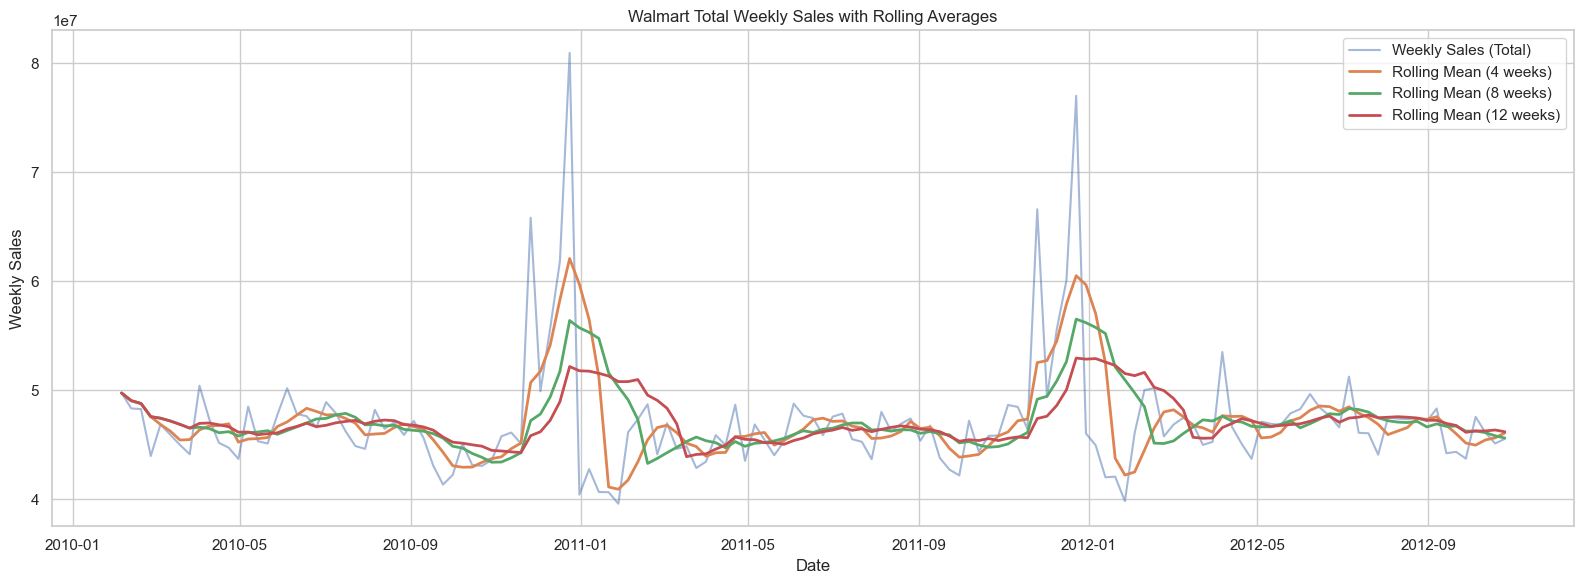

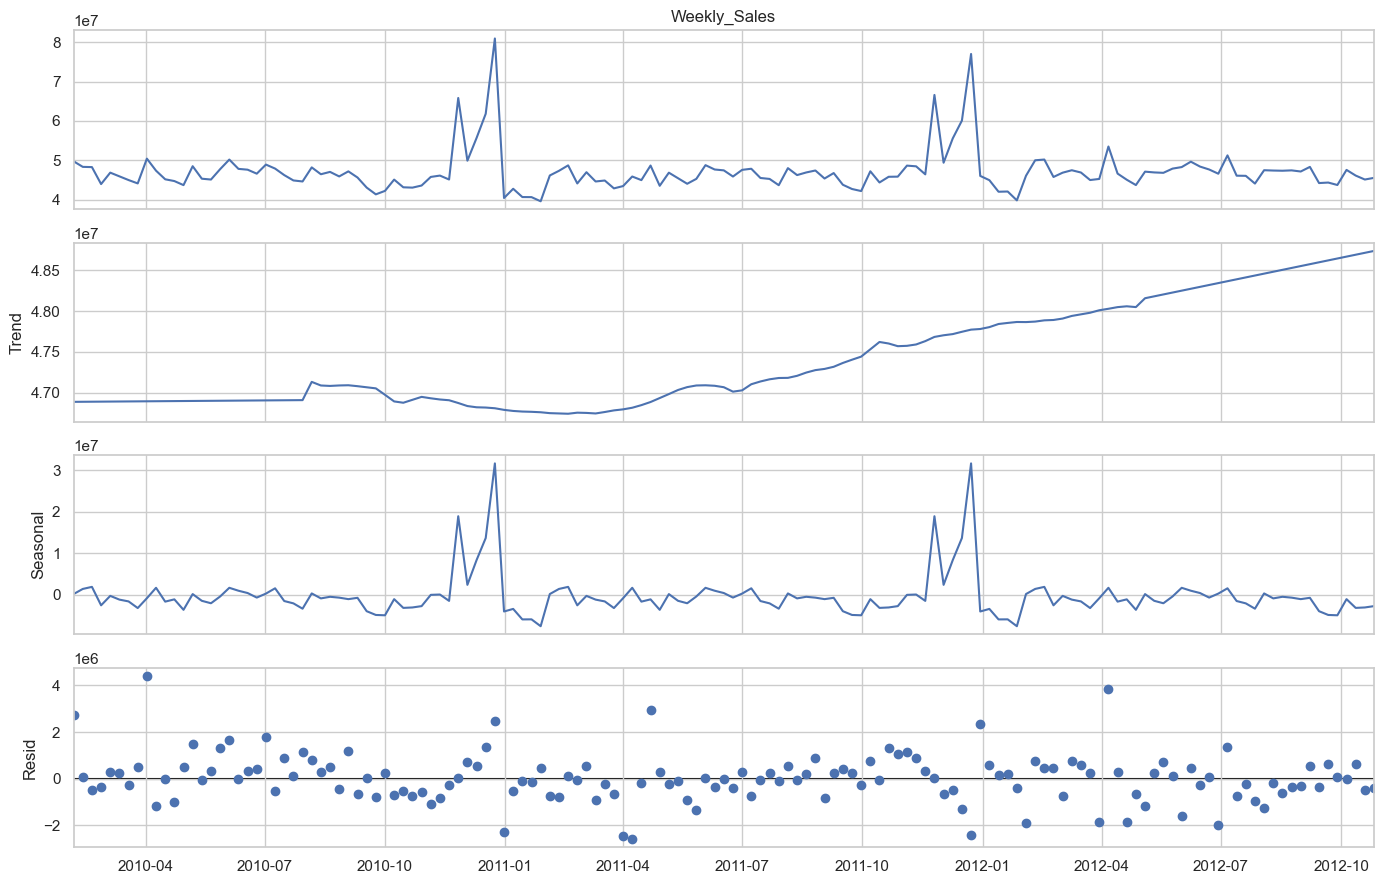

Seasonal decomposition complete: trend, seasonal, and residual components generated.


In [28]:
# Rolling averages and seasonal decomposition on total weekly sales
from statsmodels.tsa.seasonal import seasonal_decompose

weekly_total = (
    sales_df.groupby('Date', as_index=False)['Weekly_Sales']
    .sum()
    .sort_values('Date')
    .set_index('Date')
)

# Enforce weekly frequency for decomposition
weekly_total = weekly_total.asfreq('W-FRI')
weekly_total['Weekly_Sales'] = weekly_total['Weekly_Sales'].interpolate()

for window in [4, 8, 12]:
    weekly_total[f'rolling_mean_{window}'] = weekly_total['Weekly_Sales'].rolling(window=window, min_periods=1).mean()

plt.figure(figsize=(16, 6))
plt.plot(weekly_total.index, weekly_total['Weekly_Sales'], label='Weekly Sales (Total)', alpha=0.5)
plt.plot(weekly_total.index, weekly_total['rolling_mean_4'], label='Rolling Mean (4 weeks)', linewidth=2)
plt.plot(weekly_total.index, weekly_total['rolling_mean_8'], label='Rolling Mean (8 weeks)', linewidth=2)
plt.plot(weekly_total.index, weekly_total['rolling_mean_12'], label='Rolling Mean (12 weeks)', linewidth=2)
plt.title('Walmart Total Weekly Sales with Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.tight_layout()
plt.show()

# Seasonal decomposition (52 weeks approximates annual weekly seasonality)
decomp = seasonal_decompose(
    weekly_total['Weekly_Sales'],
    model='additive',
    period=52,
    extrapolate_trend='freq'
)

fig = decomp.plot()
fig.set_size_inches(14, 9)
plt.tight_layout()
plt.show()

print('Seasonal decomposition complete: trend, seasonal, and residual components generated.')

In [29]:
# Time-based train/test split (last 20% as test)
feature_cols = [
    'Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment',
    'year', 'month', 'weekofyear', 'day', 'dayofweek', 'quarter',
    'lag_1', 'lag_2', 'lag_4', 'lag_8', 'rolling_mean_4', 'rolling_std_4'
]

target_col = 'Weekly_Sales'
model_df = model_df.sort_values('Date').reset_index(drop=True)

split_idx = int(len(model_df) * 0.8)
train_df = model_df.iloc[:split_idx].copy()
test_df = model_df.iloc[split_idx:].copy()

X_train = train_df[feature_cols]
y_train = train_df[target_col]
X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"Train size: {len(train_df)}")
print(f"Test size: {len(test_df)}")
print(f"Train range: {train_df['Date'].min().date()} to {train_df['Date'].max().date()}")
print(f"Test range: {test_df['Date'].min().date()} to {test_df['Date'].max().date()}")

Train size: 4860
Test size: 1215
Train range: 2010-04-02 to 2012-04-20
Test range: 2012-04-27 to 2012-10-26


## Bonus 2: Time-Aware Validation with Gradient Boosting Libraries
This section performs time-aware cross-validation (`TimeSeriesSplit`) for LightGBM and XGBoost. If either library is not importable due to local runtime dependencies, the notebook falls back to `HistGradientBoostingRegressor` so validation remains reproducible.

In [30]:
# Time-aware validation for LightGBM / XGBoost (with robust fallback)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import HistGradientBoostingRegressor

boosting_candidates = {}
import_errors = {}

try:
    from lightgbm import LGBMRegressor
    boosting_candidates['LightGBM Regressor'] = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.03,
        num_leaves=31,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        verbose=-1
    )
except Exception as exc:
    import_errors['LightGBM Regressor'] = str(exc)

try:
    from xgboost import XGBRegressor
    boosting_candidates['XGBoost Regressor'] = XGBRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
except Exception as exc:
    import_errors['XGBoost Regressor'] = str(exc)

if not boosting_candidates:
    print('LightGBM and XGBoost are unavailable in this runtime. Using sklearn fallback model for time-aware validation.')
    for model_name, message in import_errors.items():
        print(f'- {model_name} import error: {message[:140]}')

    boosting_candidates['HistGradientBoosting (fallback)'] = HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_depth=8,
        max_iter=500,
        random_state=42
    )

tscv = TimeSeriesSplit(n_splits=5)
cv_rows = []

for model_name, model_obj in boosting_candidates.items():
    for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train), start=1):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        model_obj.fit(X_tr, y_tr)
        val_pred = model_obj.predict(X_val)
        val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))
        cv_rows.append({'Model': model_name, 'Fold': fold, 'RMSE': val_rmse})

cv_df = pd.DataFrame(cv_rows)
cv_summary_df = cv_df.groupby('Model', as_index=False)['RMSE'].mean().sort_values('RMSE').reset_index(drop=True)

time_aware_model_name = cv_summary_df.loc[0, 'Model']

if time_aware_model_name == 'LightGBM Regressor':
    time_aware_model = LGBMRegressor(
        n_estimators=500,
        learning_rate=0.03,
        num_leaves=31,
        subsample=0.9,
        colsample_bytree=0.9,
        random_state=42,
        verbose=-1
    )
elif time_aware_model_name == 'XGBoost Regressor':
    time_aware_model = XGBRegressor(
        n_estimators=500,
        learning_rate=0.03,
        max_depth=6,
        subsample=0.9,
        colsample_bytree=0.9,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
else:
    time_aware_model = HistGradientBoostingRegressor(
        learning_rate=0.05,
        max_depth=8,
        max_iter=500,
        random_state=42
    )

print('Time-aware CV mean RMSE by model:')
print(cv_summary_df.to_string(index=False))
print(f'\nSelected model from time-aware validation: {time_aware_model_name}')

Time-aware CV mean RMSE by model:
             Model          RMSE
 XGBoost Regressor 138114.308277
LightGBM Regressor 138467.741568

Selected model from time-aware validation: XGBoost Regressor


In [31]:
# Train multiple regression models and evaluate
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': make_pipeline(StandardScaler(), Ridge(alpha=1.0, random_state=42)),
    'Lasso Regression': make_pipeline(StandardScaler(), Lasso(alpha=0.05, max_iter=30000, tol=1e-2, random_state=42)),
    'Random Forest Regressor': RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1),
    'Gradient Boosting Regressor': GradientBoostingRegressor(random_state=42),
    'Extra Trees Regressor': ExtraTreesRegressor(n_estimators=300, random_state=42, n_jobs=-1)
}

# Include the best time-aware boosting model from Bonus 2
if 'time_aware_model' in globals() and 'time_aware_model_name' in globals():
    models[time_aware_model_name] = time_aware_model
    print(f"Added time-aware model: {time_aware_model_name}")

results = []
predictions = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    results.append({'Model': name, 'MAE': mae, 'RMSE': rmse, 'R2': r2})
    predictions[name] = y_pred

results_df = pd.DataFrame(results).sort_values(['RMSE', 'MAE']).reset_index(drop=True)
print("Model Performance")
print("- Lower MAE/RMSE is better")
print("- Higher R2 is better")
results_df

Added time-aware model: XGBoost Regressor
Model Performance
- Lower MAE/RMSE is better
- Higher R2 is better


,Model,MAE,RMSE,R2
0,Extra Trees Regressor,36906.352112,53236.688079,0.990064
1,XGBoost Regressor,38965.950709,53974.912133,0.989787
2,Random Forest Regressor,38327.564154,54834.516820,0.989459
3,Gradient Boosting Regressor,43120.217170,61333.220271,0.986812
4,Ridge Regression,57181.127217,76692.473900,0.979380
5,Lasso Regression,58560.079107,78546.703128,0.978371
6,Linear Regression,61343.594103,82339.236468,0.976232


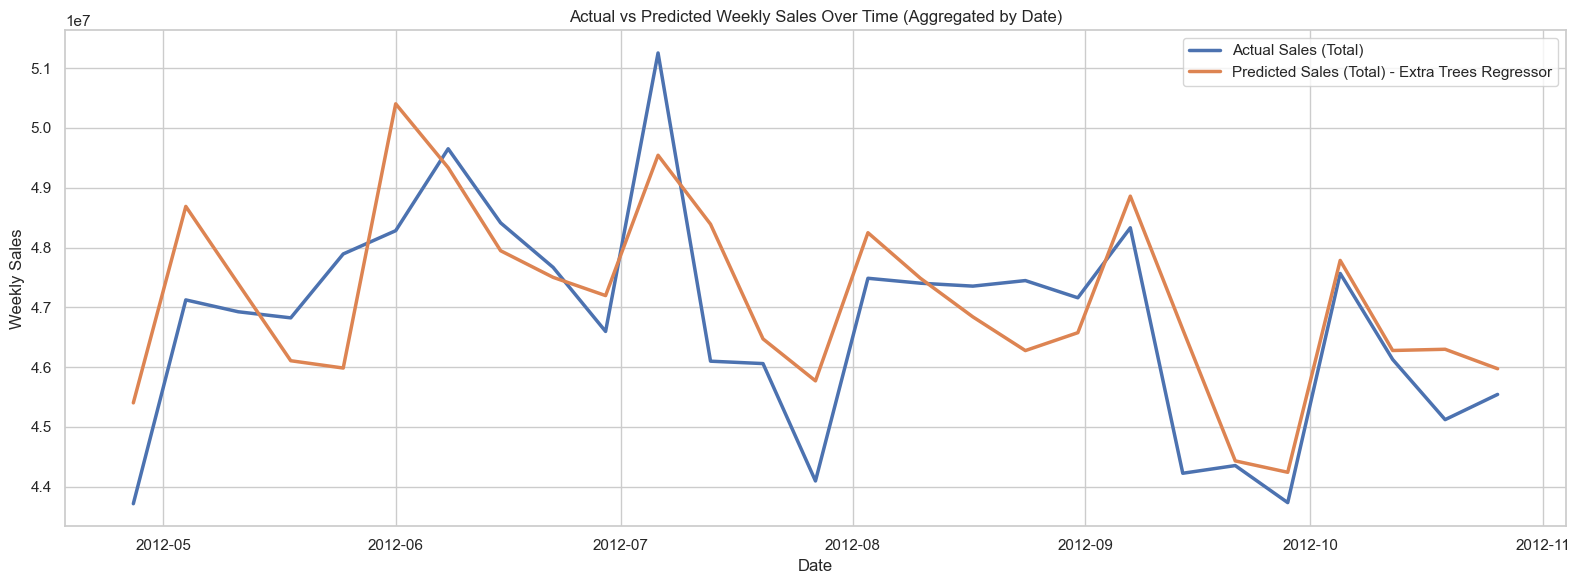

Best model: Extra Trees Regressor
Best RMSE: 53236.69


In [32]:
# Plot actual vs predicted values over time (best model)
best_model_name = results_df.loc[0, 'Model']
best_preds = predictions[best_model_name]

plot_df = test_df[['Date', 'Weekly_Sales']].copy()
plot_df['Predicted_Sales'] = best_preds
plot_df = plot_df.sort_values('Date')

# Aggregate by date across stores for a clearer time-series comparison
plot_by_date = (
    plot_df.groupby('Date', as_index=False)[['Weekly_Sales', 'Predicted_Sales']]
    .sum()
    .sort_values('Date')
)

plt.figure(figsize=(16, 6))
plt.plot(plot_by_date['Date'], plot_by_date['Weekly_Sales'], label='Actual Sales (Total)', linewidth=2.5)
plt.plot(plot_by_date['Date'], plot_by_date['Predicted_Sales'], label=f'Predicted Sales (Total) - {best_model_name}', linewidth=2.5)
plt.title('Actual vs Predicted Weekly Sales Over Time (Aggregated by Date)')
plt.xlabel('Date')
plt.ylabel('Weekly Sales')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Best model: {best_model_name}")
print(f"Best RMSE: {results_df.loc[0, 'RMSE']:.2f}")

In [33]:
# Forecast next period sales with the best model
best_model = models[best_model_name]
latest_row = model_df.sort_values('Date').iloc[-1].copy()
forecast_date = latest_row['Date'] + pd.Timedelta(days=7)

next_features = latest_row[feature_cols].copy()
next_features['year'] = forecast_date.year
next_features['month'] = forecast_date.month
next_features['weekofyear'] = int(forecast_date.isocalendar().week)
next_features['day'] = forecast_date.day
next_features['dayofweek'] = forecast_date.dayofweek
next_features['quarter'] = ((forecast_date.month - 1) // 3) + 1

next_features_df = pd.DataFrame([next_features])
next_sales_forecast = best_model.predict(next_features_df)[0]

print("Next-Period Sales Forecast")
print("=" * 40)
print(f"Selected model: {best_model_name}")
print(f"Store (reference row): {int(latest_row['Store'])}")
print(f"Last known date: {latest_row['Date'].date()}")
print(f"Forecast date: {forecast_date.date()}")
print(f"Predicted weekly sales: {next_sales_forecast:,.2f}")

print("\nTop 3 Models by RMSE")
print(results_df[['Model', 'RMSE', 'MAE', 'R2']].head(3).to_string(index=False))

Next-Period Sales Forecast
Selected model: Extra Trees Regressor
Store (reference row): 45
Last known date: 2012-10-26
Forecast date: 2012-11-02
Predicted weekly sales: 751,822.04

Top 3 Models by RMSE
                  Model         RMSE          MAE       R2
  Extra Trees Regressor 53236.688079 36906.352112 0.990064
      XGBoost Regressor 53974.912133 38965.950709 0.989787
Random Forest Regressor 54834.516820 38327.564154 0.989459


## Conclusion
This project produced a consistent and reproducible Walmart weekly sales forecasting pipeline using time-based splitting and lagged temporal features.

- **Time-aware cross-validation (5-fold `TimeSeriesSplit`)** selected **XGBoost Regressor** with mean RMSE **138,114.31** versus **138,467.74** for LightGBM.
- **Holdout test evaluation (last 20% of timeline)** identified **Extra Trees Regressor** as the best model with **RMSE 53,236.69**, **MAE 36,906.35**, and **R² 0.990064**.
- The **top-3 holdout models by RMSE** were: Extra Trees Regressor, XGBoost Regressor, and Random Forest Regressor.
- The **next-period forecast** for **2012-11-02** was **751,822.04** in weekly sales.

These results confirm strong predictive performance and practical business usability for near-term planning tasks such as inventory and staffing decisions.